In [12]:
from datetime import datetime, timedelta
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve
from transformers import (
    BertTokenizer,
    BertModel,
    BertForSequenceClassification,
    AdamW,
    AutoTokenizer,
    TFAutoModel,
    pipeline,
)
from tqdm import tqdm
import math
import numbers
import torch.utils.data as utils
import ast
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Lambda, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [13]:
train_data = np.load('train_data.npy')
val_data = np.load('val_data.npy')
test_data = np.load('test_data.npy')
train_data_use = np.load('train_data_use.npy')
val_data_use = np.load('val_data_use.npy')
test_data_use = np.load('test_data_use.npy')
train_timestamps_padded = np.load('train_timestamps_padded.npy')
val_timestamps_padded = np.load('val_timestamps_padded.npy')
test_timestamps_padded = np.load('test_timestamps_padded.npy')
train_labels = np.load('train_labels.npy')
val_labels = np.load('val_labels.npy')
test_labels = np.load('test_labels.npy')
emoberta = np.load('emoberta_full.npy', allow_pickle=True)
emoberta_padded = tf.keras.preprocessing.sequence.pad_sequences(emoberta, padding='post', maxlen=1265)

In [16]:
np.random.seed(0)

data = np.vstack((train_data, val_data, test_data))
data_use = np.vstack((train_data_use, val_data_use, test_data_use))
time = np.vstack((train_timestamps_padded, val_timestamps_padded, test_timestamps_padded))
labels = np.vstack((train_labels, val_labels, test_labels))
# emobed = np.vstack((train_data_emobed, val_data_emobed, test_data_emobed))

train_data, val_test_data, train_emobed_data, val_test_emobed_data, train_labels, val_test_labels, train_timestamps_padded, val_test_timestamps_padded = train_test_split(
    data,
    emoberta_padded,
    labels,
    time,
    test_size=0.2,
    random_state=5
)
val_data, test_data, val_labels, test_labels, val_timestamps_padded, test_timestamps_padded, val_data_emobed, test_data_emobed = train_test_split(
    val_test_data,
    val_test_labels,
    val_test_timestamps_padded,
    val_test_emobed_data,
    train_size=0.5,
    random_state=5
)

train_data_use, val_test_data_use = train_test_split(
    data_use,
    test_size=0.2,
    random_state=0
)
val_data_use, test_data_use = train_test_split(
    val_test_data_use,
    train_size=0.5,
    random_state=0
)

In [17]:
MAX_SEQ_LENGTH = 1265
# Define the number of classes
NUM_CLASSES = 2
# Define the learning rate decay parameters
INIT_LR = 0.001
DECAY_FACTOR = 0.1
DECAY_EPOCHS = 10
# Define the GRU parameters
LSTM_HIDDEN_DIM = 256
GRU_HIDDEN_DIM = 256
DROPOUT_RATE = 0.2

In [18]:
# normalizing time inputs was super important!!
max_time = 1./np.max(train_timestamps_padded)
train_timestamps_padded = (train_timestamps_padded*max_time).astype(np.float32)
val_timestamps_padded = (val_timestamps_padded*max_time).astype(np.float32)
test_timestamps_padded = (test_timestamps_padded*max_time).astype(np.float32)

In [ ]:
## LSTM Time Decay

In [23]:
# Define the time decay function
def time_decay(epoch):
    lrate = INIT_LR * pow(DECAY_FACTOR, np.floor((1 + epoch) / DECAY_EPOCHS))
    return lrate


# Define the input layers
EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH, 768), name="embeddings")
TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name="times")
decay_layer = Lambda(
    lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400),
    name="decay_layer",
)(TimeInput)
decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name="decay_layer_2")
lstm_layer = LSTM(
    LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm"
)(EmbeddingInput, mask=EmbeddingInput._keras_mask)
multiply = tf.keras.layers.Multiply(name="multiply")([lstm_layer, decay_layer_2])
flatten_layer = tf.keras.layers.Flatten(name="flatten")(multiply)
outputs = Dense(NUM_CLASSES, activation="softmax")(flatten_layer)
model = Model(inputs=[EmbeddingInput, TimeInput], outputs=outputs)
optimizer = Adam(learning_rate=INIT_LR)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)


In [24]:
lr_scheduler = LearningRateScheduler(time_decay)
history = model.fit(
    [train_data, train_timestamps_padded],
    train_labels,
    validation_data=([val_data, val_timestamps_padded], val_labels),
    epochs=10,
    batch_size=32,
    callbacks=[lr_scheduler],
)


Epoch 1/10


2023-06-02 13:49:22.269109: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1523343360 exceeds 10% of free system memory.


13/13 [==============================] - 31s 2s/step - loss: 1.1458 - accuracy: 0.6480 - auc: 0.6719 - precision: 0.6480 - recall: 0.6480 - val_loss: 0.4673 - val_accuracy: 0.8571 - val_auc: 0.8784 - val_precision: 0.8571 - val_recall: 0.8571 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - 27s 2s/step - loss: 0.4673 - accuracy: 0.7883 - auc: 0.8744 - precision: 0.7883 - recall: 0.7883 - val_loss: 0.5446 - val_accuracy: 0.8980 - val_auc: 0.9027 - val_precision: 0.8980 - val_recall: 0.8980 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - 27s 2s/step - loss: 0.3370 - accuracy: 0.8724 - auc: 0.9299 - precision: 0.8724 - recall: 0.8724 - val_loss: 0.4229 - val_accuracy: 0.8980 - val_auc: 0.8988 - val_precision: 0.8980 - val_recall: 0.8980 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - 27s 2s/step - loss: 0.2338 - accuracy: 0.9209 - auc: 0.9662 - precision: 0.9209 - recall: 0.9209 - val_loss: 0.4755 - val_accuracy: 0.8980 - val_auc: 0.9075 -

In [25]:
model.evaluate([test_data, test_timestamps_padded], test_labels)

2/2 [==============================] - 1s 522ms/step - loss: 0.3264 - accuracy: 0.9388 - auc: 0.9463 - precision: 0.9388 - recall: 0.9388


[0.3263731896877289,
 0.9387755393981934,
 0.9462723731994629,
 0.9387755393981934,
 0.9387755393981934]

In [26]:
test_preds = model.predict([test_data, test_timestamps_padded])
test_preds = np.argmax(test_preds, axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
)

# Calculate AUROC
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate AUPRC
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate accuracy
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate recall
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
# Calculate precision
test_precision = precision_score(
    np.argmax(test_labels, axis=1), test_preds, average="macro"
)
print("Test AUROC:", test_auroc)
print("Test AUPRC:", test_auprc)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)

2/2 [==============================] - 2s 518ms/step
Test AUROC: 0.9318181818181819
Test AUPRC: 0.9
Test Accuracy: 0.9387755102040817
Test Recall: 0.9318181818181819
Test Precision: 0.95
Test F1 Score: 0.9370988446726572


In [ ]:
## LSTM with Attention

In [45]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Attention
import keras.backend as K


# Define the time decay function
def time_decay(epoch):
    lrate = INIT_LR * pow(DECAY_FACTOR, np.floor((1 + epoch) / DECAY_EPOCHS))
    return lrate


class attention(Layer):
    def __init__(self, **kwargs):
        super(attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight", shape=(input_shape[-1], 1), initializer="normal"
        )
        self.b = self.add_weight(
            name="att_bias", shape=(input_shape[1], 1), initializer="zeros"
        )
        super(attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        attention_weights = at  # Return attention weights
        return K.sum(output, axis=1), attention_weights

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

    def get_config(self):
        return super(attention, self).get_config()


# Define the input layers
EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH, 768), name="embeddings")
TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name="times")
decay_layer = Lambda(
    lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400),
    name="decay_layer",
)(TimeInput)
decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name="decay_layer_2")
lstm_layer = LSTM(
    LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm"
)(EmbeddingInput, mask=EmbeddingInput._keras_mask)
multiply = tf.keras.layers.Multiply(name="multiply")([lstm_layer, decay_layer_2])

attention_layer = attention(name="attention")
att_out, attention_weights = attention_layer(multiply)

attention_scores = tf.keras.layers.Flatten(name="attention_scores")(attention_weights)
outputs = Dense(NUM_CLASSES, activation="softmax", name="output_real")(att_out)

# Create a separate output for attention scores
# attention_scores = tf.keras.layers.Flatten(name='attention_scores')(attention)

model = Model(inputs=[EmbeddingInput, TimeInput], outputs=[outputs, attention_scores])
optimizer = Adam(learning_rate=INIT_LR)
model.compile(
    loss={
        "output_real": "binary_crossentropy",
        "attention_scores": "mean_absolute_error",
    },
    optimizer=optimizer,
    metrics={"output_real": ["accuracy"]},
)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 times (InputLayer)             [(None, 1265)]       0           []                               
                                                                                                  
 embeddings (InputLayer)        [(None, 1265, 768)]  0           []                               
                                                                                                  
 decay_layer (Lambda)           (None, 1265)         0           ['times[0][0]']                  
                                                                                                  
 lstm (LSTM)                    (None, 1265, 256)    1049600     ['embeddings[0][0]']             
                                                                                            

In [46]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=10)
history = model.fit(
    [train_data, train_timestamps_padded],
    {"output_real": train_labels, "attention_scores": np.zeros((392, 1265))},
    validation_data=(
        [val_data, val_timestamps_padded],
        {"output_real": val_labels, "attention_scores": np.zeros((49, 1265))},
    ),
    epochs=6,
    batch_size=16,
    callbacks=[lr_scheduler],
    shuffle=False,
)

Epoch 1/6


2023-06-01 15:15:44.298659: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1523343360 exceeds 10% of free system memory.


25/25 [==============================] - 55s 2s/step - loss: 0.6947 - output_real_loss: 0.6940 - attention_scores_loss: 7.9051e-04 - output_real_accuracy: 0.5893 - val_loss: 0.6222 - val_output_real_loss: 0.6214 - val_attention_scores_loss: 7.9051e-04 - val_output_real_accuracy: 0.7755 - lr: 0.0010
Epoch 2/6
25/25 [==============================] - 38s 2s/step - loss: 0.5336 - output_real_loss: 0.5328 - attention_scores_loss: 7.9051e-04 - output_real_accuracy: 0.7704 - val_loss: 0.4213 - val_output_real_loss: 0.4205 - val_attention_scores_loss: 7.9051e-04 - val_output_real_accuracy: 0.8367 - lr: 0.0010
Epoch 3/6
25/25 [==============================] - 38s 2s/step - loss: 0.5843 - output_real_loss: 0.5835 - attention_scores_loss: 7.9051e-04 - output_real_accuracy: 0.6964 - val_loss: 0.5647 - val_output_real_loss: 0.5639 - val_attention_scores_loss: 7.9051e-04 - val_output_real_accuracy: 0.7143 - lr: 0.0010
Epoch 4/6
25/25 [==============================] - 38s 2s/step - loss: 0.4024 - 

In [47]:
test_preds = model.predict([test_data, test_timestamps_padded])
test_preds = np.argmax(test_preds[0], axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
)

# Calculate AUROC
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate AUPRC
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate accuracy
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate recall
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
# Calculate precision
test_precision = precision_score(
    np.argmax(test_labels, axis=1), test_preds, average="macro"
)
print("Test AUROC:", test_auroc)
print("Test AUPRC:", test_auprc)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)

2/2 [==============================] - 2s 538ms/step
Test AUROC: 0.9183333333333332
Test AUPRC: 0.8872163265306122
Test Accuracy: 0.9183673469387755
Test Recall: 0.9183333333333333
Test Precision: 0.9183333333333333
Test F1 Score: 0.9183333333333333


In [48]:
test_preds = model.predict([test_data, test_timestamps_padded])
scores = test_preds[1]

2/2 [==============================] - 1s 529ms/step


In [43]:
num_subjects = scores.shape[0]
num_sentences = scores.shape[1]
embedding_dim = scores.shape[2]

attention_weights = np.zeros((num_subjects, num_sentences))

for i in range(num_subjects):
    for j in range(num_sentences):
        attention_weights[i, j] = np.dot(test_data[i, j], scores[i, j])

In [14]:
attention_weights.shape

(49, 1265)

In [55]:
attention_weights

array([[ 0.13727953,  0.06680126,  0.2991108 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.16282681,  0.15440184, -0.08720291, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00626363, -0.01205555, -0.01209223, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.01325723, -0.01074065,  0.00668882, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00463635,  0.00783895,  0.00039899, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07219961, -0.2352502 , -0.3490521 , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
df_concat = pd.read_csv('df_concat.csv')

In [17]:
import re
import numpy as np
big_list_of_arrays = []
for i in range(len(df_concat)):
    string = df_concat['embeddings_bert'].iloc[i]
    embedding_str = string.replace('\n', '')
    embedding_str = embedding_str.replace('  ', ' ')
    embedding_str = embedding_str.replace('  ', ' ')
    embedding_str = embedding_str.replace('  ', ' ')
    embedding_str = embedding_str.replace(', dtype=float32', '')
    array_strings = re.findall(r'array\(\[(.*?)\]\)', embedding_str)
    arrays = [np.array(ast.literal_eval(s)) for s in array_strings]
    big_list_of_arrays.append(arrays)

In [18]:
df_concat['embeddings_bert_converted'] = big_list_of_arrays

In [94]:
# # unpadded_attent_weights = [a[(d!=0).all(1)] for a,d in zip(attention_weights, test_data)]
# # lens2 = [len(a) for a in unpadded_attent_weights]
# # attention_weights.shape, (test_data!=0).all(axis=2).shape
# lens = [len(eval(t)) for t in df_concat['Text'].values]
# intersect = set(lens2).intersection(set(lens))

In [20]:
## subject2749 - 1 (77), subject3856 - 1 (197), subject8884 - 0 (30), subject8214 - 1 (224), subject1773 - 0 (234)

In [65]:
from scipy.special import softmax
arr_softmax = softmax(attention_weights, axis=1)

In [66]:
test_subjects_5 = ['subject2749', 'subject3856', 'subject8884', 'subject8214', 'subject1773']

In [78]:
unpadded_attent_weights = [a[(d!=0).all(1)] for a,d in zip(attention_weights, test_data)]

In [ ]:
arr_softmax = np.exp(arr / temperature) / np.sum(np.exp(arr / temperature))

In [93]:
temperature = 1.5
normalized_attention = []
for i in range(len(unpadded_attent_weights)):
    arr_softmax = np.exp(unpadded_attent_weights[i] / temperature) / np.sum(np.exp(unpadded_attent_weights[i] / temperature))
    normalized_attention.append(arr_softmax)

In [95]:
subject2749_attention = normalized_attention[0]
subject2749_texts = eval(df_concat['Text'].iloc[77])

In [96]:
df_subject2749 = pd.DataFrame({
    'Attention': subject2749_attention,
    'Text': subject2749_texts
})

In [146]:
pd.set_option('display.max_colwidth', None)

In [97]:
df_subject2749_sorted = df_subject2749.sort_values(by='Attention', ascending=False)

In [98]:
df_subject2749_sorted

,Attention,Text
88,0.014335,Didn't they though? They throw so much free play at me it's stupid. Makes it very difficult to not 'waste' it? How f'd is that? It's worse because I know everyone there. We're all addicted. We feed each other the fallacy of the next big win. We cheered each other and threw hundreds at buddies to get them back in the game. I'm such a dumbass.
89,0.013833,"Your statement about ""driving with Hope""..to win back your losses. Wow. How many times I felt the same! You wrote out exactly what so many of us go through. That damn money loss depression! I'm still feeling it from months ago, last year, the year before that. It's horrible. Terrifying. Humiliating. Shameful. The GUILT. Et cetera! In my experience, it doesn't matter if I win or lose, I still continue to want MORE. When does it end for us? The tentacles of need, greed, want-it latches deeply into our brain. That's addiction. We know it's bad. We want more. The cycle is neverending. How do we stop? We have to choose to stop. Nobody can make you. This money loss depression can only be decreased by no longer throwing our money away. Sure sounds easy to hear someone say it, but it's another thing to do it. Relapse is common. All we can do is take one step forward each day. My advice? Get busy living your life and finding other things to occupy your time. It's hard to do when all you can think of is getting that loss back! Yet, if you did, wouldn't you just gamble just a bit more to get yourself ahead? We will never be the ultimate winner. Ever. It is designed so we are the losers. Truth! I know that feeling, that rush, or dread, when you go into a casino. Are you ready to ban yourself yet? That's a good move in the healthy direction. Post anytime. There are plenty of us who are here to help, because hearing your struggle helps us too. Best wishes friend"
24,0.013302,"Stop all gambling now before you become one of the people who have blown through thousands. It would be just a matter of time. Sounds like you like that adrenaline too. It's your brain pulling you towards that addiction. There is no in between. Just STOP. Find something athletic, or anything else (no alcohol tho) to get away from the betting. You will be thankful later. It's a HORRIBLE addiction. It will ruin your life. Good luck!"
23,0.012556,"Your post could have been mine. Unbelievable. I am more convinced now more than ever that gambling is a true addiction. If people only knew what we felt on the inside! Your results were good, but it doesn't matter. We still go back. We still feel like shit. We still ultimately lose it all. We are never satisfied. Coming to Reddit is a start. You will see others in the same boat looking for understanding. Believe me, we understand. I have lost nearly everything, but come payday time? My heart rate goes up. I feel the adrenaline. I want to WIN and I will stay all day at the casino betting on my roulette. ""Today I'll just bet on color because it's better odds."" The things I would tell myself to rationalize it all. The worst part? I made friends at the casino. If they lose, I give them money. If I lose, they give me money. We all want to stay there together and we cheer each other on. Addicts feeding addicts. Look, you aren't alone in this. I have no money and I'm trying like hell to get a payday loan. Nobody will because my history is horrible. I make great money but where does it go? To the numbers! To black. To red. Someone else manages my money now, and that has almost saved me. However, the budget I set aside each week still dreams of going back to play roulette to ""make more."" Endless. My advice? Take one day at a time. I pray it works. You can do this. We can do this. Sending you good thoughts. Stay strong."
22,0.012492,"A great post. I could have written the exact same thing. You nailed it. We win a million? Yep. We want to go ""make"" more! It messes up our brain. That is for certain. Being broke, broken, and done-- how many times do we rep

In [99]:
subject3856_attention = normalized_attention[1]
subject3856_texts = eval(df_concat['Text'].iloc[197])
df_subject3856 = pd.DataFrame({'Attention': subject3856_attention, 'Text': subject3856_texts})
df_subject3856_sorted = df_subject3856.sort_values(by='Attention', ascending=False)
df_subject3856_sorted

,Attention,Text
490,0.001724,"For those that believe in setting a limit or have a money management strategy when heading into the casino. Bullshit. Same event, same outcome, same vicious cycle. Too many times, I noticed when I chase my losses. 9 out of 10 times. I head into the downward spiral. I place bigger bets in an attempt to recuperate, never works. I totally let my guard down tonight, my hard earned money and the overtime I've been putting in. Down the drain in just a few hours. I'm quite the disappointment."
614,0.001681,"The casino industry is definitely shady, just as the desperate gambler who is willing do shady things to get the money. The whole gambling trap is messed up."
360,0.001644,"I went into gambling, with the dream that I can be rich and be financially free. I never won more than 8k, and that was when I was running lucky. I had a broken dream where if I had won 100k, I would put it down for a house. I hear countless stories of people win big money and lost it all. But seldom do we hear how the gambler's life is change for the better after the big win. My theory is once the gambler has won the big money. A part of his soul now belongs to the devil."
711,0.001628,"In today's world, I believe human problems have gotten much more complex. Just because there's a variety of addictions, too much. Not to mention there's a list of mental illness, gives me grey hair just thinking about it. We cannot pin point the exact cause and there's no end in sight, as population increase and resource decrease. We become a product of our environment. I do however have hope. As long as we have good people out there, and people that wants to change for the better, earth will be a better place. Day 1. Namaste."
670,0.001621,"I think winning big money will not solve our problems completely, it might add more fuel to the fire and prolong our habit. If I can recall, how many times did I win and put it back? But not spending the winnings on anything worthwhile, Countless. Finding ways to stop is the best course of action."
...,...,...
712,0.000618,"Thanks, I will do so."
474,0.000572,"You are a brave soul to bare all the years of misery in a single post. If you don't mind my question, what sort of gambling were you involved in?"
467,0.000563,"Sometimes I believe that my gambling behavior will follow me for time to come. Regardless, I must make an effort to change. And I hope you do so as well. Cheers."
487,0.000550,Thank you for this. I enjoy listening to motivational talks. But this will open my mind up to a different view.


In [100]:
subject8214_attention = normalized_attention[3]
subject8214_texts = eval(df_concat['Text'].iloc[224])
df_subject8214 = pd.DataFrame({'Attention': subject8214_attention, 'Text': subject8214_texts})
df_subject8214_sorted = df_subject8214.sort_values(by='Attention', ascending=False)
df_subject8214_sorted

,Attention,Text
7,0.082569,"Mad gambler, keep trying to stop but cant, just spunked 250 at the bookies there, might not seem like lots to some people but thats pretty much my free money for the whole month and I just got paid Thursday. At least my bills are covered but looks like it will be a long month telling my friends I am cutting back drinking or not in the mood as a shit excuse for not coming out and doing things, also avoiding letting my better half know I got no money cause I bet it all like a total clown. Ahh well need to use it as motivation not to do it again, am sure I will though and thats the shittest part, really wish I had never started gambling, an absolute fools sport"
12,0.076112,"Massive scam, paid today and already 140 down, spoke to my gambling councillor lady on the phone today, talked about tools to not gamble, felt like I had it sussed, 6 hours later and its already fucked. Gambling is exploitation of the stupid, problem is Im that stupid I let them do it again and again, 100% biggest scam going on in UK atm and unlike most other scams its 100% legal to fleece people without lots of money of every penny they have, stay strong my friend"
2,0.074877,Boom!
0,0.072513,"Keep it up, 45 days is amazing pal"
9,0.071431,"Having no freinds must be really tough, is there not any clubs you could join nearby to help with making freinds? I see from your posts on this thread you are a musican? you could always put up a sign in a local music shop looking for a band to join or someone to collabarate with musically? Stay off the gambling its a fucking horrible illlness when you let it overcome you. stay strong"
1,0.071409,Keep going! Its worth 1000x more to you than any millionaires trying to steal it!
10,0.070794,"cheers for the replys guys, its a fucking shitter isnt it haha"
5,0.070189,Keep going
13,0.068477,"Payday today, spoke to my telephone councillor lady who calls me every week this morning, felt pretty confident for the coming month, few hours later and Ive fucked up already, 140 lost today, maybe not a huge amount to some but a decent amount to me (500 or thereabouts disposable income for the month, I know how lucky I am to have this, its much more than lots of people I know) but thats almost 1/3rd of that spent in only a few hours on absolutely nothing, pathetic behaviour. Just Downloaded a timer there and Im 20 minutes gambling free, If I can make it to end of the month Ill be in a much better position than I was yesterday, currently seriously doubting my own ability to do this though unfortunately. However tomorrow is another day and if I can abstain for tomorrow and I only got 30 more days to hit a month and be back on track. Fingers crossed!"
4,0.068178,"I signed up to Gamstop, hasnt stopped me entirely and I still find ways but its shit hot, 100% recommended"


In [34]:
## GRUD time decay BERT

In [27]:
# Define the time decay function
def time_decay(epoch):
    lrate = INIT_LR * pow(DECAY_FACTOR, np.floor((1 + epoch) / DECAY_EPOCHS))
    return lrate


# Define the input layers
EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH, 768), name="embeddings")
TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name="times")
decay_layer = Lambda(
    lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400),
    name="decay_layer",
)(TimeInput)
decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name="decay_layer_2")
gru_layer = GRU(
    GRU_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="gru"
)(EmbeddingInput, mask=EmbeddingInput._keras_mask)
multiply = tf.keras.layers.Multiply(name="multiply")([gru_layer, decay_layer_2])
flatten_layer = tf.keras.layers.Flatten(name="flatten")(multiply)
outputs = Dense(NUM_CLASSES, activation="softmax")(flatten_layer)
model = Model(inputs=[EmbeddingInput, TimeInput], outputs=outputs)
optimizer = Adam(learning_rate=INIT_LR)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)


In [28]:
lr_scheduler = LearningRateScheduler(time_decay)
history = model.fit(
    [train_data, train_timestamps_padded],
    train_labels,
    validation_data=([val_data, val_timestamps_padded], val_labels),
    epochs=10,
    batch_size=32,
    callbacks=[lr_scheduler],
)


Epoch 1/10


2023-06-02 13:59:11.906096: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1523343360 exceeds 10% of free system memory.


13/13 [==============================] - 27s 2s/step - loss: 1.7738 - accuracy: 0.5969 - auc: 0.6091 - precision: 0.5969 - recall: 0.5969 - val_loss: 1.6936 - val_accuracy: 0.8367 - val_auc: 0.8176 - val_precision: 0.8367 - val_recall: 0.8367 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - 23s 2s/step - loss: 0.6664 - accuracy: 0.8189 - auc: 0.8571 - precision: 0.8189 - recall: 0.8189 - val_loss: 0.5372 - val_accuracy: 0.8980 - val_auc: 0.9042 - val_precision: 0.8980 - val_recall: 0.8980 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - 23s 2s/step - loss: 0.2067 - accuracy: 0.9209 - auc: 0.9730 - precision: 0.9209 - recall: 0.9209 - val_loss: 0.4680 - val_accuracy: 0.8776 - val_auc: 0.8867 - val_precision: 0.8776 - val_recall: 0.8776 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - 23s 2s/step - loss: 0.1291 - accuracy: 0.9694 - auc: 0.9941 - precision: 0.9694 - recall: 0.9694 - val_loss: 0.4930 - val_accuracy: 0.9184 - val_auc: 0.9005 -

In [29]:
model.evaluate([test_data, test_timestamps_padded], test_labels)

2/2 [==============================] - 1s 573ms/step - loss: 0.0935 - accuracy: 0.9592 - auc: 0.9958 - precision: 0.9592 - recall: 0.9592


[0.0935334786772728,
 0.9591836929321289,
 0.9958350658416748,
 0.9591836929321289,
 0.9591836929321289]

In [30]:
test_preds = model.predict([test_data, test_timestamps_padded])
test_preds = np.argmax(test_preds, axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
)

# Calculate AUROC
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate AUPRC
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate accuracy
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate recall
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
# Calculate precision
test_precision = precision_score(
    np.argmax(test_labels, axis=1), test_preds, average="macro"
)
print("Test AUROC:", test_auroc)
print("Test AUPRC:", test_auprc)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)


2/2 [==============================] - 2s 572ms/step
Test AUROC: 0.9545454545454545
Test AUPRC: 0.9310344827586207
Test Accuracy: 0.9591836734693877
Test Recall: 0.9545454545454546
Test Precision: 0.9655172413793103
Test F1 Score: 0.9583333333333333


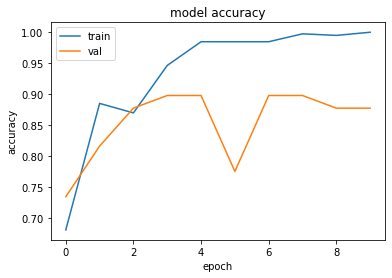

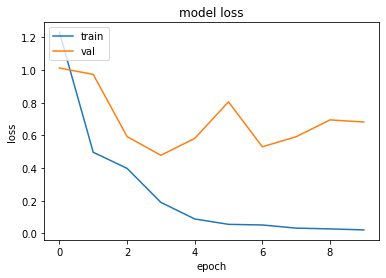

In [87]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## GRUD time decay USE

In [78]:
# # Define the time decay function
# def time_decay(epoch):
#     lrate = INIT_LR * pow(DECAY_FACTOR, np.floor((1+epoch)/DECAY_EPOCHS))
#     return lrate

# # Define the input layers
# EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH,512), name='embeddings')
# TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name='times')
# decay_layer = Lambda(lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400), name='decay_layer')(TimeInput)
# decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name='decay_layer_2')
# gru_layer = GRU(GRU_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name='gru')(EmbeddingInput, mask=EmbeddingInput._keras_mask)
# multiply = tf.keras.layers.Multiply(name='multiply')([gru_layer, decay_layer_2])
# flatten_layer = tf.keras.layers.Flatten(name='flatten')(multiply)
# outputs = Dense(NUM_CLASSES, activation='softmax')(flatten_layer)
# model = Model(inputs=[EmbeddingInput, TimeInput], outputs=outputs)
# optimizer = Adam(learning_rate=INIT_LR)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# lr_scheduler = LearningRateScheduler(time_decay)
# history = model.fit([train_data_use, train_timestamps_padded], train_labels, validation_data=([val_data_use, val_timestamps_padded], val_labels), epochs=10, batch_size=32, callbacks=[lr_scheduler])
# test_preds = model.predict([test_data_use, test_timestamps_padded])
# test_preds = np.argmax(test_preds, axis=1)
# test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average='macro')
# from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score
# # Calculate AUROC
# test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
# # Calculate AUPRC
# test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
# # Calculate accuracy
# test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
# # Calculate recall
# test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average='macro')
# # Calculate precision
# test_precision = precision_score(np.argmax(test_labels, axis=1), test_preds, average='macro')
# print('Test AUROC:', test_auroc)
# print('Test AUPRC:', test_auprc)
# print('Test Accuracy:', test_accuracy)
# print('Test Recall:', test_recall)
# print('Test Precision:', test_precision)
# print('Test F1 Score:', test_f1_score)

In [ ]:
## No Time decay

In [59]:
# Define the time decay function
def time_decay(epoch):
    lrate = INIT_LR * pow(DECAY_FACTOR, np.floor((1 + epoch) / DECAY_EPOCHS))
    return lrate


# Define the input layers
EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH, 768), name="embeddings")
TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name="times")
decay_layer = Lambda(
    lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400),
    name="decay_layer",
)(TimeInput)
decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name="decay_layer_2")
gru_layer = GRU(
    GRU_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="gru"
)(EmbeddingInput, mask=EmbeddingInput._keras_mask)
# multiply = tf.keras.layers.Multiply(name='multiply')([gru_layer, decay_layer_2])
flatten_layer = tf.keras.layers.Flatten(name="flatten")(gru_layer)
outputs = Dense(NUM_CLASSES, activation="softmax")(flatten_layer)
model = Model(inputs=[EmbeddingInput, TimeInput], outputs=outputs)
optimizer = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
lr_scheduler = LearningRateScheduler(time_decay)
history = model.fit(
    [train_data, train_timestamps_padded],
    train_labels,
    validation_data=([val_data, val_timestamps_padded], val_labels),
    epochs=10,
    batch_size=32,
    callbacks=[lr_scheduler],
)


Epoch 1/10
13/13 [==============================] - 26s 2s/step - loss: 1.6828 - accuracy: 0.6327 - val_loss: 0.3831 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - 23s 2s/step - loss: 0.4352 - accuracy: 0.8801 - val_loss: 0.3746 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - 23s 2s/step - loss: 0.2122 - accuracy: 0.9235 - val_loss: 0.4207 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - 23s 2s/step - loss: 0.1562 - accuracy: 0.9362 - val_loss: 0.2804 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 5/10
13/13 [==============================] - 22s 2s/step - loss: 0.1146 - accuracy: 0.9745 - val_loss: 0.4378 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 6/10
13/13 [==============================] - 23s 2s/step - loss: 0.0872 - accuracy: 0.9770 - val_loss: 0.3349 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 7/10
13/13 [==============================] - 23s 2s/step - loss: 0.0597 - a

In [60]:
model.evaluate([test_data, test_timestamps_padded], test_labels)

2/2 [==============================] - 1s 522ms/step - loss: 0.1198 - accuracy: 0.9184


[0.11979472637176514, 0.918367326259613]

In [61]:
test_preds = model.predict([test_data, test_timestamps_padded])
test_preds = np.argmax(test_preds, axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
)

# Calculate AUROC
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate AUPRC
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate accuracy
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate recall
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
# Calculate precision
test_precision = precision_score(
    np.argmax(test_labels, axis=1), test_preds, average="macro"
)
print("Test AUROC:", test_auroc)
print("Test AUPRC:", test_auprc)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)

2/2 [==============================] - 2s 537ms/step
Test AUROC: 0.9140350877192983
Test AUPRC: 0.8413703431511109
Test Accuracy: 0.9183673469387755
Test Recall: 0.9140350877192982
Test Precision: 0.9140350877192982
Test F1 Score: 0.9140350877192982


In [ ]:
##USE embeds

In [15]:
# Define the input layers
EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH, 512), name="embeddings")
TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name="times")
decay_layer = Lambda(
    lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400),
    name="decay_layer",
)(TimeInput)
decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name="decay_layer_2")
gru_layer = GRU(
    GRU_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="gru"
)(EmbeddingInput, mask=EmbeddingInput._keras_mask)
# multiply = tf.keras.layers.Multiply(name='multiply')([gru_layer, decay_layer_2])
flatten_layer = tf.keras.layers.Flatten(name="flatten")(gru_layer)
outputs = Dense(NUM_CLASSES, activation="softmax")(flatten_layer)
model = Model(inputs=[EmbeddingInput, TimeInput], outputs=outputs)
optimizer = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
lr_scheduler = LearningRateScheduler(time_decay)
history = model.fit(
    [train_data_use, train_timestamps_padded],
    train_labels,
    validation_data=([val_data_use, val_timestamps_padded], val_labels),
    epochs=10,
    batch_size=32,
    callbacks=[lr_scheduler],
)
test_preds = model.predict([test_data_use, test_timestamps_padded])
test_preds = np.argmax(test_preds, axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_precision = precision_score(
    np.argmax(test_labels, axis=1), test_preds, average="macro"
)
print("Test AUROC:", test_auroc)
print("Test AUPRC:", test_auprc)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)


2023-05-23 15:32:17.770881: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1015562240 exceeds 10% of free system memory.


Epoch 1/10
13/13 [==============================] - 32s 2s/step - loss: 0.6368 - accuracy: 0.6480 - val_loss: 0.6495 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - 22s 2s/step - loss: 0.3839 - accuracy: 0.8469 - val_loss: 0.6014 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - 22s 2s/step - loss: 0.2969 - accuracy: 0.8980 - val_loss: 0.5347 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - 22s 2s/step - loss: 0.2683 - accuracy: 0.9005 - val_loss: 0.5757 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 5/10
13/13 [==============================] - 22s 2s/step - loss: 0.2033 - accuracy: 0.9260 - val_loss: 0.5989 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 6/10
13/13 [==============================] - 22s 2s/step - loss: 0.1761 - accuracy: 0.9464 - val_loss: 0.8000 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 7/10
13/13 [==============================] - 22s 2s/step - loss: 0.1840 - a

In [ ]:
## Emotional LSTM

In [41]:
!mkdir -p checkpoints

/var/lib/oar/.batch_job_bashrc: line 5: /home/aparfenova/.bashrc: No such file or directory


In [64]:
checkpoint_filepath = './checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# 42 RS

In [24]:
train_emobed_data = np.squeeze(train_emobed_data)
val_data_emobed = np.squeeze(val_data_emobed)
test_data_emobed = np.squeeze(test_data_emobed)


# Define the time decay function
def time_decay(epoch):
    lrate = INIT_LR * pow(DECAY_FACTOR, np.floor((1 + epoch) / DECAY_EPOCHS))
    return lrate


from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
)

# Define the input layers
EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH, 768), name="embeddings")
EmotionInput = Input(shape=(MAX_SEQ_LENGTH, 7), name="EmotionInput")
TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name="times")
decay_layer = Lambda(
    lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400),
    name="decay_layer",
)(TimeInput)
decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name="decay_layer_2")
lstm_layer = LSTM(
    LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm"
)(EmbeddingInput, mask=EmbeddingInput._keras_mask)
lstm_layer_emotion = LSTM(
    LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm2"
)(EmotionInput, mask=EmotionInput._keras_mask)
multiply = tf.keras.layers.Multiply(name="multiply")(
    [lstm_layer, lstm_layer_emotion, decay_layer_2]
)
flatten_layer = tf.keras.layers.Flatten(name="flatten")(multiply)
outputs = Dense(NUM_CLASSES, activation="softmax")(flatten_layer)
model = Model(inputs=[EmbeddingInput, TimeInput, EmotionInput], outputs=outputs)
optimizer = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
lr_scheduler = LearningRateScheduler(time_decay)
history = model.fit(
    [train_data, train_timestamps_padded, train_emobed_data],
    train_labels,
    validation_data=([val_data, val_timestamps_padded, val_data_emobed], val_labels),
    epochs=10,
    batch_size=32,
    callbacks=[lr_scheduler],
)


2023-06-05 17:42:29.461062: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1523343360 exceeds 10% of free system memory.


Epoch 1/10
13/13 [==============================] - 46s 3s/step - loss: 0.7021 - accuracy: 0.6301 - val_loss: 0.7270 - val_accuracy: 0.4898 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - 40s 3s/step - loss: 0.5951 - accuracy: 0.7219 - val_loss: 0.5072 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - 38s 3s/step - loss: 0.6171 - accuracy: 0.7194 - val_loss: 0.4222 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - 38s 3s/step - loss: 0.3796 - accuracy: 0.8750 - val_loss: 0.2495 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 5/10
13/13 [==============================] - 38s 3s/step - loss: 0.4187 - accuracy: 0.8393 - val_loss: 0.2344 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 6/10
13/13 [==============================] - 37s 3s/step - loss: 0.4527 - accuracy: 0.8367 - val_loss: 0.2915 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 7/10
13/13 [==============================] - 38s 3s/step - loss: 0.3274 - a

In [25]:
test_preds = model.predict([test_data, test_timestamps_padded, test_data_emobed])
test_preds = np.argmax(test_preds, axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_precision = precision_score(
    np.argmax(test_labels, axis=1), test_preds, average="macro"
)
print("Test AUROC:", test_auroc)
print("Test AUPRC:", test_auprc)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)


2/2 [==============================] - 3s 679ms/step
Test AUROC: 0.9383333333333334
Test AUPRC: 0.9065620094191523
Test Accuracy: 0.9387755102040817
Test Recall: 0.9383333333333332
Test Precision: 0.939799331103679
Test F1 Score: 0.9386733416770963


In [ ]:
# 0 RS

In [38]:
# train_emobed_data = np.squeeze(train_emobed_data)
# val_data_emobed = np.squeeze(val_data_emobed)
# test_data_emobed = np.squeeze(test_data_emobed)
EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH, 768), name="embeddings")
EmotionInput = Input(shape=(MAX_SEQ_LENGTH, 7), name="EmotionInput")
TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name="times")
decay_layer = Lambda(
    lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400),
    name="decay_layer",
)(TimeInput)
decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name="decay_layer_2")
lstm_layer = LSTM(
    LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm"
)(EmbeddingInput, mask=EmbeddingInput._keras_mask)
lstm_layer_emotion = LSTM(
    LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm2"
)(EmotionInput, mask=EmotionInput._keras_mask)
multiply = tf.keras.layers.Multiply(name="multiply")(
    [lstm_layer, lstm_layer_emotion, decay_layer_2]
)
flatten_layer = tf.keras.layers.Flatten(name="flatten")(multiply)
outputs = Dense(NUM_CLASSES, activation="softmax")(flatten_layer)
model = Model(inputs=[EmbeddingInput, TimeInput, EmotionInput], outputs=outputs)
optimizer = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
lr_scheduler = LearningRateScheduler(time_decay)
history = model.fit(
    [train_data, train_timestamps_padded, train_emobed_data],
    train_labels,
    validation_data=([val_data, val_timestamps_padded, val_data_emobed], val_labels),
    epochs=7,
    batch_size=32,
    callbacks=[lr_scheduler],
)
test_preds = model.predict([test_data, test_timestamps_padded, test_data_emobed])
test_preds = np.argmax(test_preds, axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_precision = precision_score(
    np.argmax(test_labels, axis=1), test_preds, average="macro"
)
print("Test AUROC:", test_auroc)
print("Test AUPRC:", test_auprc)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)


Epoch 1/7
13/13 [==============================] - 41s 3s/step - loss: 0.6636 - accuracy: 0.6097 - val_loss: 0.6323 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 2/7
13/13 [==============================] - 36s 3s/step - loss: 0.5934 - accuracy: 0.7526 - val_loss: 0.5697 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 3/7
13/13 [==============================] - 35s 3s/step - loss: 0.5440 - accuracy: 0.7832 - val_loss: 0.4490 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 4/7
13/13 [==============================] - 35s 3s/step - loss: 0.4248 - accuracy: 0.8367 - val_loss: 0.3163 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 5/7
13/13 [==============================] - 35s 3s/step - loss: 0.3300 - accuracy: 0.8878 - val_loss: 0.2577 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 6/7
13/13 [==============================] - 37s 3s/step - loss: 0.2724 - accuracy: 0.9133 - val_loss: 0.2133 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 7/7
2/2 [==============================] - 3s 616ms/step
Test AUROC: 0.93452380952

In [ ]:
#420 RS

In [47]:
train_emobed_data = np.squeeze(train_emobed_data)
val_data_emobed = np.squeeze(val_data_emobed)
test_data_emobed = np.squeeze(test_data_emobed)
EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH, 768), name="embeddings")
EmotionInput = Input(shape=(MAX_SEQ_LENGTH, 7), name="EmotionInput")
TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name="times")
decay_layer = Lambda(
    lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400),
    name="decay_layer",
)(TimeInput)
decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name="decay_layer_2")
lstm_layer = LSTM(
    LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm"
)(EmbeddingInput, mask=EmbeddingInput._keras_mask)
lstm_layer_emotion = LSTM(
    LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm2"
)(EmotionInput, mask=EmotionInput._keras_mask)
multiply = tf.keras.layers.Multiply(name="multiply")(
    [lstm_layer, lstm_layer_emotion, decay_layer_2]
)
flatten_layer = tf.keras.layers.Flatten(name="flatten")(multiply)
outputs = Dense(NUM_CLASSES, activation="softmax")(flatten_layer)
model = Model(inputs=[EmbeddingInput, TimeInput, EmotionInput], outputs=outputs)
optimizer = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
lr_scheduler = LearningRateScheduler(time_decay)
history = model.fit(
    [train_data, train_timestamps_padded, train_emobed_data],
    train_labels,
    validation_data=([val_data, val_timestamps_padded, val_data_emobed], val_labels),
    epochs=12,
    batch_size=32,
    callbacks=[lr_scheduler],
)
test_preds = model.predict([test_data, test_timestamps_padded, test_data_emobed])
test_preds = np.argmax(test_preds, axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_precision = precision_score(
    np.argmax(test_labels, axis=1), test_preds, average="macro"
)
print("Test AUROC:", test_auroc)
print("Test AUPRC:", test_auprc)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)


Epoch 1/12
13/13 [==============================] - 41s 3s/step - loss: 0.7207 - accuracy: 0.6250 - val_loss: 0.7574 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 2/12
13/13 [==============================] - 35s 3s/step - loss: 0.6940 - accuracy: 0.5612 - val_loss: 0.6847 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 3/12
13/13 [==============================] - 35s 3s/step - loss: 0.6537 - accuracy: 0.6786 - val_loss: 0.5919 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 4/12
13/13 [==============================] - 35s 3s/step - loss: 0.5642 - accuracy: 0.7832 - val_loss: 0.5334 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 5/12
13/13 [==============================] - 36s 3s/step - loss: 0.5795 - accuracy: 0.6939 - val_loss: 0.5093 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 6/12
13/13 [==============================] - 36s 3s/step - loss: 0.4352 - accuracy: 0.8597 - val_loss: 0.6976 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 7/12
13/13 [==============================] - 35s 3s/step - loss: 0.4827 - a

In [48]:
for i in range(5, 16):
    train_emobed_data = np.squeeze(train_emobed_data)
    val_data_emobed = np.squeeze(val_data_emobed)
    test_data_emobed = np.squeeze(test_data_emobed)
    EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH, 768), name="embeddings")
    EmotionInput = Input(shape=(MAX_SEQ_LENGTH, 7), name="EmotionInput")
    TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name="times")
    decay_layer = Lambda(
        lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400),
        name="decay_layer",
    )(TimeInput)
    decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name="decay_layer_2")
    lstm_layer = LSTM(
        LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm"
    )(EmbeddingInput, mask=EmbeddingInput._keras_mask)
    lstm_layer_emotion = LSTM(
        LSTM_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name="lstm2"
    )(EmotionInput, mask=EmotionInput._keras_mask)
    multiply = tf.keras.layers.Multiply(name="multiply")(
        [lstm_layer, lstm_layer_emotion, decay_layer_2]
    )
    flatten_layer = tf.keras.layers.Flatten(name="flatten")(multiply)
    outputs = Dense(NUM_CLASSES, activation="softmax")(flatten_layer)
    model = Model(inputs=[EmbeddingInput, TimeInput, EmotionInput], outputs=outputs)
    optimizer = Adam(learning_rate=INIT_LR)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    lr_scheduler = LearningRateScheduler(time_decay)
    history = model.fit(
        [train_data, train_timestamps_padded, train_emobed_data],
        train_labels,
        validation_data=(
            [val_data, val_timestamps_padded, val_data_emobed],
            val_labels,
        ),
        epochs=i,
        batch_size=32,
        callbacks=[lr_scheduler],
    )
    test_preds = model.predict([test_data, test_timestamps_padded, test_data_emobed])
    test_preds = np.argmax(test_preds, axis=1)
    test_f1_score = f1_score(
        np.argmax(test_labels, axis=1), test_preds, average="macro"
    )
    test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
    test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
    test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
    test_recall = recall_score(
        np.argmax(test_labels, axis=1), test_preds, average="macro"
    )
    test_precision = precision_score(
        np.argmax(test_labels, axis=1), test_preds, average="macro"
    )
    print("Test AUROC:", test_auroc)
    print("Test AUPRC:", test_auprc)
    print("Test Accuracy:", test_accuracy)
    print("Test Recall:", test_recall)
    print("Test Precision:", test_precision)
    print("Test F1 Score:", test_f1_score)


Epoch 1/5
13/13 [==============================] - 48s 3s/step - loss: 0.6654 - accuracy: 0.6199 - val_loss: 5.9703 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 2/5
13/13 [==============================] - 35s 3s/step - loss: 1.1396 - accuracy: 0.5587 - val_loss: 0.6814 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 3/5
13/13 [==============================] - 36s 3s/step - loss: 0.6834 - accuracy: 0.7270 - val_loss: 0.6624 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 4/5
13/13 [==============================] - 36s 3s/step - loss: 0.6344 - accuracy: 0.7602 - val_loss: 0.5349 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 5/5
2/2 [==============================] - 3s 611ms/step
Test AUROC: 0.8077586206896552
Test AUPRC: 0.7928219563687545
Test Accuracy: 0.8367346938775511
Test Recall: 0.8077586206896552
Test Precision: 0.8642857142857143
Test F1 Score: 0.8198529411764707
Epoch 1/6
13/13 [==============================] - 41s 3s/step - loss: 0.6784 - accuracy: 0.5918 - val_loss: 0.6108 - val_accuracy: 

In [70]:
model.load_weights(checkpoint_filepath)

In [71]:
test_preds = model.predict(
    [test_data, test_timestamps_padded, test_data_emobed[:, :, -7:]]
)
test_preds = np.argmax(test_preds, axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average="macro")
test_precision = precision_score(
    np.argmax(test_labels, axis=1), test_preds, average="macro"
)
print("Test AUROC:", test_auroc)
print("Test AUPRC:", test_auprc)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)


2/2 [==============================] - 1s 560ms/step
Test AUROC: 0.9232758620689655
Test AUPRC: 0.9245705945213334
Test Accuracy: 0.9183673469387755
Test Recall: 0.9232758620689655
Test Precision: 0.9132996632996633
Test F1 Score: 0.9166666666666667


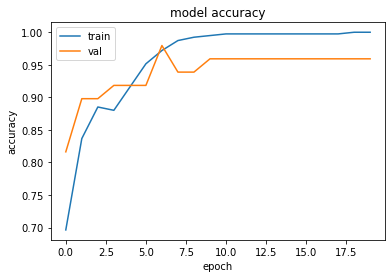

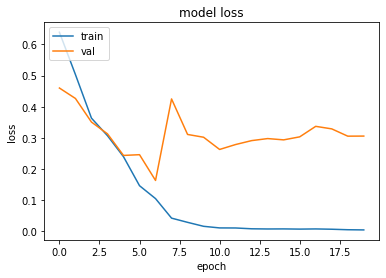

In [73]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Concatenation of embeddings, the full vector = 768+7 = 775

In [ ]:
df_concat["emobeds"] = 0
huge_emobed_lst = []
for i in range(len(df_concat)):
    concatenated_array = np.concatenate(
        (
            np.array(df_concat["embeddings_bert_converted"].iloc[i]),
            np.squeeze(np.array(df_concat["emotions"].iloc[i])),
        ),
        axis=1,
    )
    huge_emobed_lst.append(concatenated_array)
df_concat["emobeds"] = huge_emobed_lst


In [30]:
# Define the time decay function
def time_decay(epoch):
    lrate = INIT_LR * pow(DECAY_FACTOR, np.floor((1+epoch)/DECAY_EPOCHS))
    return lrate

# Define the input layers
EmbeddingInput = Input(shape=(MAX_SEQ_LENGTH,775), name='embeddings')

TimeInput = Input(shape=(MAX_SEQ_LENGTH,), name='times')
decay_layer = Lambda(lambda t: tf.math.exp(-(t - tf.roll(t, shift=1, axis=1)) / 86400), name='decay_layer')(TimeInput)
decay_layer_2 = tf.expand_dims(decay_layer, axis=-1, name='decay_layer_2')
gru_layer = GRU(GRU_HIDDEN_DIM, dropout=DROPOUT_RATE, return_sequences=True, name='gru')(EmbeddingInput, mask=EmbeddingInput._keras_mask)
multiply = tf.keras.layers.Multiply(name='multiply')([gru_layer, decay_layer_2])
flatten_layer = tf.keras.layers.Flatten(name='flatten')(multiply)
outputs = Dense(NUM_CLASSES, activation='softmax')(flatten_layer)
model = Model(inputs=[EmbeddingInput, TimeInput], outputs=outputs)
optimizer = Adam(learning_rate=INIT_LR)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
lr_scheduler = LearningRateScheduler(time_decay)
history = model.fit([train_emobed_data, train_timestamps_padded], train_labels, validation_data=([val_data_emobed, val_timestamps_padded], val_labels), epochs=10, batch_size=32, callbacks=[lr_scheduler])

Epoch 1/10
13/13 [==============================] - 27s 2s/step - loss: 2.6378 - accuracy: 0.5612 - val_loss: 1.8099 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - 23s 2s/step - loss: 1.1319 - accuracy: 0.5714 - val_loss: 1.6476 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - 23s 2s/step - loss: 0.6926 - accuracy: 0.6837 - val_loss: 1.4682 - val_accuracy: 0.5918 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - 23s 2s/step - loss: 0.5286 - accuracy: 0.8163 - val_loss: 1.3039 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 5/10
13/13 [==============================] - 23s 2s/step - loss: 0.4928 - accuracy: 0.8367 - val_loss: 1.3888 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 6/10
13/13 [==============================] - 23s 2s/step - loss: 0.4743 - accuracy: 0.8622 - val_loss: 1.7968 - val_accuracy: 0.4694 - lr: 0.0010
Epoch 7/10
13/13 [==============================] - 23s 2s/step - loss: 0.3668 - a

In [31]:
model.evaluate([test_data_emobed, test_timestamps_padded], test_labels)

2/2 [==============================] - 1s 579ms/step - loss: 2.7029 - accuracy: 0.4490


[2.7028777599334717, 0.44897958636283875]

In [32]:
test_preds = model.predict([test_data_emobed, test_timestamps_padded])
test_preds = np.argmax(test_preds, axis=1)
test_f1_score = f1_score(np.argmax(test_labels, axis=1), test_preds, average='macro')
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score
# Calculate AUROC
test_auroc = roc_auc_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate AUPRC
test_auprc = average_precision_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate accuracy
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)
# Calculate recall
test_recall = recall_score(np.argmax(test_labels, axis=1), test_preds, average='macro')
# Calculate precision
test_precision = precision_score(np.argmax(test_labels, axis=1), test_preds, average='macro')
print('Test AUROC:', test_auroc)
print('Test AUPRC:', test_auprc)
print('Test Accuracy:', test_accuracy)
print('Test Recall:', test_recall)
print('Test Precision:', test_precision)
print('Test F1 Score:', test_f1_score)


2/2 [==============================] - 2s 575ms/step
Test AUROC: 0.578125
Test AUPRC: 0.7072704081632653
Test Accuracy: 0.4489795918367347
Test Recall: 0.578125
Test Precision: 0.6931818181818181
Test F1 Score: 0.4138236597252991


In [ ]:
##Viz

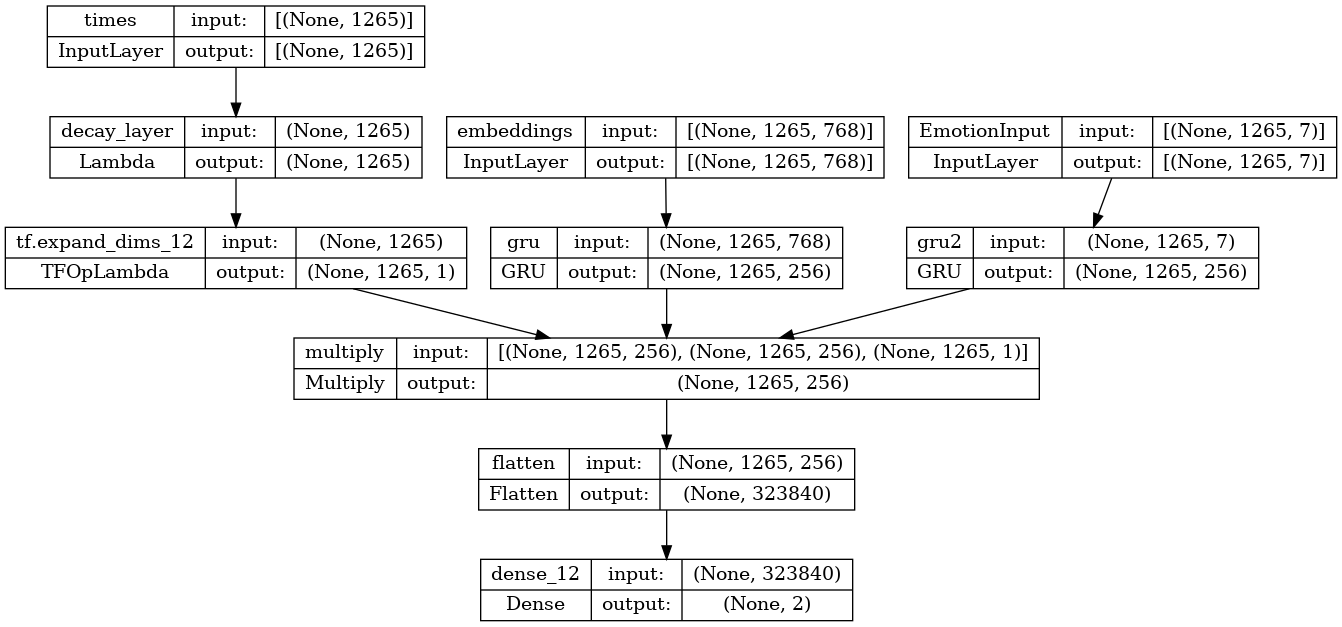

In [96]:
dot_img_file = '/tmp/model_2.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)